In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/relsize/relSize.mat


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):
    n=len(net.features) + len(net.classifier)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        
        for  (sub_name, sub_layer) in (layer.named_children()):
            ltype=sub_layer.__class__.__name__
            if ltype == 'Conv2d':
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'],
                            padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
            elif ltype=='Dropout':
                i=i-1
            elif ltype== 'ReLU':
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1



    return res


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag):
    # Load the VGG16 model
    model1 = vgg16(pretrained=True)
    model1.eval()  # Set the model to evaluation mode
    model2=vgg16(pretrained=False)
    model2.eval()
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract the image data from the loaded dictionary
    # stim_images = stim_data['stim'][0]
#     print(stim_data['stim'])

    nimages =  len(stim_data)
    if dagg_flag==0:
        features1=  []
        features2=[]
        i=0
        for ind in range(nimages):
            print("Image:",ind)
            # Convert the numpy array to PIL Image
            image_array = stim_data[ind][0]
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
                # Perform inference using the model
#             with torch.no_grad():
#                 output = model(image_tensor)

           # Append the features to the list
            features1.append(vl_simplenn(model1, image_tensor))
            features2.append(vl_simplenn(model2, image_tensor))
#             if ind%4==3:
#                 print('Calculating Check_RelSize_Effect of 4 images')
#                 check_relsize_effect(features)
#                 i=i+1
#                 features=[]
        return features1,features2


In [4]:
import numpy as np
from scipy.stats import sem
from sklearn.preprocessing import normalize

def check_relsize_effect(features_relsize):
    nimages = len(features_relsize)
    nL = 37 # len(features_relsize[0]) - 1
    nGroups = 6#24
    percentage_selected = 0.07  # percentage of neurons

    miLayerwise_selected_mean = np.zeros(nL)
    miLayerwise_selected_sem = np.zeros(nL)

    nTetrad = np.zeros((nL, nGroups))
    print("nTrtrad",nTetrad.shape)
    array_neuron_stats = np.zeros((nL, 3))  # neurons per layer, visually active neurons, tetrads showing positive RE

    for layerid in range(nL):
        print("Layer Id",layerid)
        # getting response and normalizing
        tmp_neu=np.ravel(features_relsize[0][layerid]['x'].detach().numpy())
        nNeurons = len(tmp_neu)
        print("NNeurons",nNeurons)
        array_neuron_stats[layerid, 0] = nNeurons
        response = np.zeros((nNeurons, nimages))
        for ind in range(nimages):
            response[:, ind] = np.ravel(features_relsize[ind][layerid]['x'].detach().numpy())

        # normalizing it
        nresponse = normalize(response.T, norm='max').T
#         print("nresponse",nresponse.shape)
        van = np.where(np.sum(nresponse, axis=1) > 0)[0]  # visually active neurons
        nvresponse = nresponse[van, :]  # normalized response from visually active neurons
        nvan = len(van)
#         print(van.shape)
        array_neuron_stats[layerid, 1] = nvan / nNeurons
        # init
        RE_L = np.zeros((nvan, nGroups))
        selected_tetrads = np.zeros((nvan, nGroups))
        MI_L = np.zeros((nresponse.shape[0], nGroups))
        MI_L_average = []
        count = -1
        MIn = np.zeros((nvan, nGroups))
        for group in range(nGroups):
            print('Group:',group)
            count += 1
            imag = (group * 4) + np.arange(4)
#             print("img",imag)
            # Repeating the analysis from paper.
            n_img1 = nresponse[van, imag[0]]
#             print("n_img1",n_img1.shape)
            n_img2 = nresponse[van, imag[1]]
            n_img3 = nresponse[van, imag[2]]
            n_img4 = nresponse[van, imag[3]]
            temp_sum = np.sum([n_img1, n_img2, n_img3, n_img4], axis=1)
#             print("temp_sum",temp_sum>0)
             
            n_active_tertads = np.sum(temp_sum > 0)
#             print('n_active_tetads',n_active_tertads)
            nTetrad[layerid, count] = n_active_tertads
            # removing the non active tetrads
            index = np.where(temp_sum <= 0)[0]
            n_img1[index] = np.nan
            n_img2[index] = np.nan
            n_img3[index] = np.nan
            n_img4[index] = np.nan
            mr1 = (n_img1 + n_img2) / 2
            mr2 = (n_img3 + n_img4) / 2
            mc1 = (n_img1 + n_img3) / 2
            mc2 = (n_img2 + n_img4) / 2
            T = np.vstack([n_img1, n_img2, n_img3, n_img4]).T
            re = T + np.mean(T, axis=1, keepdims=True) - np.vstack([mr1, mr1, mr2, mr2]).T - np.vstack([mc1, mc2, mc1, mc2]).T
            RE_L[:, count] = np.sum(np.abs(re), axis=1)
            # calculating MI per neurons
            d14 = np.abs(n_img1 - n_img4)
            d23 = np.abs(n_img2 - n_img3)
            MIn[:, count] = (d23 - d14) / (d14 + d23)

        # selecting tetrads
        MIn_selected = MIn.ravel()  # vectorizing the MI of tetrads
        vectorized_RE_L = RE_L.ravel()
        vectorized_RE_L[np.isnan(vectorized_RE_L)] = -9999999  # representing NaN as a large negative value
        tempV, tempI = zip(*sorted(zip(vectorized_RE_L, range(len(vectorized_RE_L))), reverse=True))
        count_active_tetrads = np.sum(nTetrad[layerid, :])
        print("cat",count_active_tetrads)
        temp_number = int(np.floor(percentage_selected * count_active_tetrads))
        print("Temp_number",temp_number)
        array_neuron_stats[layerid, 2] = temp_number / (nNeurons * nGroups)
        selected_tetrads = selected_tetrads.ravel()
        selected_tetrads[tempI[:temp_number]] = 1
        MIn_selected[selected_tetrads == 0] = np.nan

        print(f'\nAmong Selected ( max RE = {np.nanmax(tempV[:temp_number]):.2f} min RE = {np.nanmin(tempV[:temp_number]):.2f} )')
        # mean and SEM
        miLayerwise_selected_mean[layerid] = np.nanmean(MIn_selected)
        miLayerwise_selected_sem[layerid] = sem(MIn_selected, nan_policy='omit')

    return miLayerwise_selected_mean, miLayerwise_selected_sem




In [7]:
check=check_relsize_effect(f1)
check2=check_relsize_effect(f2)
mean_data.append(check[0])
mean_data.append(check2[0])

nTrtrad (37, 6)
Layer Id 0
NNeurons 150528
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 16.0
Temp_number 1

Among Selected ( max RE = 1.57 min RE = 1.57 )
Layer Id 1
NNeurons 3211264


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.71 min RE = 0.71 )


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Layer Id 2
NNeurons 3211264
Group: 0


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.73 min RE = 0.73 )


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Layer Id 3
NNeurons 3211264
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.67 min RE = 0.67 )


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Layer Id 4
NNeurons 3211264
Group: 0


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.94 min RE = 0.94 )


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Layer Id 5
NNeurons 802816
Group: 0
Group: 1


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.90 min RE = 0.90 )
Layer Id 6
NNeurons 1605632


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.65 min RE = 0.65 )
Layer Id 7
NNeurons 1605632


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.74 min RE = 0.74 )
Layer Id 8
NNeurons 1605632


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.87 min RE = 0.87 )
Layer Id 9
NNeurons 1605632


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.77 min RE = 0.77 )
Layer Id 10
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.61 min RE = 0.61 )
Layer Id 11
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.37 min RE = 0.37 )
Layer Id 12
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.56 min RE = 0.56 )
Layer Id 13
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.73 min RE = 0.73 )
Layer Id 14
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.75 min RE = 0.75 )
Layer Id 15
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.80 min RE = 0.80 )
Layer Id 16
NNeurons 802816


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.91 min RE = 0.91 )
Layer Id 17
NNeurons 200704


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 1.02 min RE = 1.02 )
Layer Id 18
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.44 min RE = 0.44 )
Layer Id 19
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.42 min RE = 0.42 )
Layer Id 20
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.27 min RE = 0.27 )
Layer Id 21
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.52 min RE = 0.52 )
Layer Id 22
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.36 min RE = 0.36 )
Layer Id 23
NNeurons 401408


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.64 min RE = 0.64 )
Layer Id 24
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.74 min RE = 0.74 )
Layer Id 25
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.53 min RE = 0.53 )
Layer Id 26
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.57 min RE = 0.57 )
Layer Id 27
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.43 min RE = 0.43 )
Layer Id 28
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.71 min RE = 0.71 )
Layer Id 29
NNeurons 100352
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.37 min RE = 0.37 )
Layer Id 30
NNeurons 100352


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)


cat 24.0
Temp_number 1

Among Selected ( max RE = 0.91 min RE = 0.91 )
Layer Id 31
NNeurons 25088
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 0.74 min RE = 0.74 )
Layer Id 32
NNeurons 4096
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 2.18 min RE = 2.18 )
Layer Id 33
NNeurons 4096
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/c

cat 24.0
Temp_number 1

Among Selected ( max RE = 1.50 min RE = 1.50 )
Layer Id 34
NNeurons 4096
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 2.06 min RE = 2.06 )
Layer Id 35
NNeurons 4096
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 1.47 min RE = 1.47 )
Layer Id 36
NNeurons 4096
Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
cat 24.0
Temp_number 1

Among Selected ( max RE = 2.17 min RE = 2.17 )


/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_33/1860593701.py:77: RuntimeWarning: invalid value encountered in divide
  MIn[:, count] = (d23 - d14) / (d14 + d23)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/c

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io



# Effect Reference Level
reference_mi=0.39;
reference_name='Vighneshvel & Arun 2015';
grey_region_name='IT Interaction effect for 7% of tetrads';
y_label='average realative size index for top 7 % of tetrads';

# Networks
# network_types = ['imagenet-vgg-verydeep-16', 'imagenet-matconvnet-vgg-verydeep-16.mat', 'imagenet-vgg-verydeep-16_randn.mat',
#                 'imagenet-vgg-face', 'imagenet-caffe-alex', 'imagenet-googlenet-dag', 'imagenet-resnet-50-dag', 'imagenet-resnet-152-dag']
# dagg_flags = [0, 0, 0, 0, 0, 0, 1, 1]
# network_short_names = ['VGG-16', 'mat.VGG-16', 'VGG-16 randn', 'VGG-face', 'Alexnet', 'Goolgenet', 'ResNet 50', 'ResNet 152']
network_types = ['/kaggle/input/resnet50/other/2/1/imagenet-vgg-verydeep-16.mat']
dagg_flags = [0]
network_short_names = ['VGG-face']



# def main():

# Load Stimuli
stim_file_name = '/kaggle/input/relsize/relSize.mat'
stim = scipy.io.loadmat(stim_file_name)['stim']
print('stim1',len(stim))


#     for iter in range(len(network_types)):
#         print(f'\n Network- {network_types[iter]} \n')
#         print('\n Extracting Features\n')
#         print('No of images;',len(stim))
f1,f2=extract_features(stim, 'network_types', 0)
#         MI_across_layers[iter] = thatcherIndex
#     check=check_relsize_effect(f)
#         dist_types = 'Euclidean'
#         y_label = 'Thatcher Index'
# #         saving_file_name = os.path.join('..', SLASH, 'results', SLASH, f'Exp01-TI,net = {network_short_names[iter]} metric = {dist_types}')
#         saving_file_name = f'results/{f"Exp01-TI_net_{network_short_names[iter]}_metric_{dist_types}"}'
#         print(saving_file_name)
#         # Effect Reference Level

# layerwise_mi_figures(thatcherIndex, [], saving_file_name, reference_mi, reference_name, dist_types, y_label)


# if __name__ == '__main__':
#     main()



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
  #  plt.savefig(file_name + '.pdf')
    plt.show()

/tmp/ipykernel_33/1456367342.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


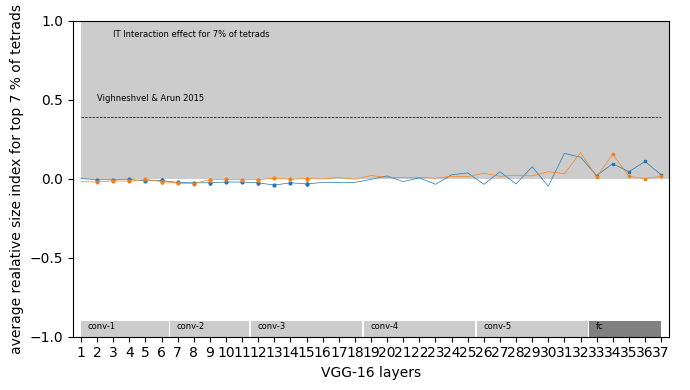

In [10]:
reference_mi=0.39;
reference_name='Vighneshvel & Arun 2015';
grey_region_name='IT Interaction effect for 7% of tetrads'
y_label='average realative size index for top 7 % of tetrads'

layerwise_mi_figures(mean_data, [], 'file_name', reference_mi, reference_name, ['VGG16,VGG16_rand'], y_label, shaded_region_name=grey_region_name)